Selected features: ['logged_in', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']
Train shape: (125973, 6), Test shape: (22544, 6)
Initial centroids shape: (3, 6)
Initial covariance matrix shape: (6, 6)
Initial inverse covariance matrix shape: (6, 6)
Converged after 26 iterations
Final covariance matrix shape: (6, 6)
Final inverse covariance matrix shape: (6, 6)
Training time: 73.75 seconds
Inference time per sample: 0.02 ms
Recall: 0.7826
Precision: 0.5557
F1 Score: 0.6499


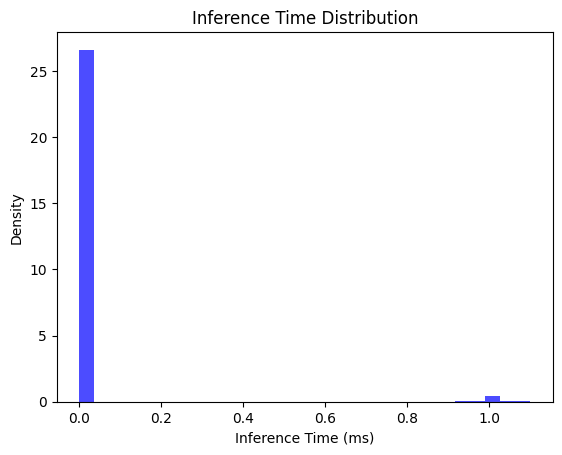

In [2]:
# Cell 1: Import libraries
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import recall_score, precision_score, f1_score
from scipy.spatial.distance import mahalanobis
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Cell 2: Load processed data
try:
    X_train = np.load('train_X.npy')
    y_train = np.load('train_y.npy')
    X_test = np.load('test_X.npy')
    y_test = np.load('test_y.npy')
    with open('train_features.pkl', 'rb') as f:
        selected_features = pickle.load(f)
    with open('train_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
except FileNotFoundError:
    print("Error: Processed data files not found. Run train_kmeans_mahalanobis.py first.")
    raise

print(f"Selected features: {selected_features}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Cell 3: Define K-means Mahalanobis class
class KMeansMahalanobis:
    def __init__(self, n_clusters, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.cov_matrix = None
        self.inv_cov_matrix = None
    
    def fit(self, X):
        """Train K-means with Mahalanobis distance."""
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        
        # Initialize centroids randomly
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[indices]
        print(f"Initial centroids shape: {self.centroids.shape}")  # Debug
        
        # Compute initial covariance matrix
        self.cov_matrix = np.cov(X.T)
        print(f"Initial covariance matrix shape: {self.cov_matrix.shape}")  # Debug
        self.cov_matrix += np.eye(self.cov_matrix.shape[0]) * 1e-6  # Regularization
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        print(f"Initial inverse covariance matrix shape: {self.inv_cov_matrix.shape}")  # Debug
        
        # K-means iterations with Mahalanobis distance
        for iteration in range(self.max_iter):
            old_centroids = self.centroids.copy()
            labels = self.predict(X)
            
            # Update centroids
            for k in range(self.n_clusters):
                if np.sum(labels == k) > 0:
                    self.centroids[k] = np.mean(X[labels == k], axis=0)
            
            # Check convergence
            if np.allclose(old_centroids, self.centroids, rtol=1e-5):
                print(f"Converged after {iteration + 1} iterations")
                break
        
        # Recompute covariance matrix with final clusters
        self.cov_matrix = np.cov(X.T)
        self.cov_matrix += np.eye(self.cov_matrix.shape[0]) * 1e-6
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        print(f"Final covariance matrix shape: {self.cov_matrix.shape}")  # Debug
        print(f"Final inverse covariance matrix shape: {self.inv_cov_matrix.shape}")  # Debug
    
    def predict(self, X):
        """Predict cluster labels using Mahalanobis distance."""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            for j in range(X.shape[0]):
                distances[j, i] = mahalanobis(X[j], self.centroids[i], self.inv_cov_matrix)
        return np.argmin(distances, axis=1)
    
    def score(self, X):
        """Compute average Mahalanobis distance to assigned centroid."""
        labels = self.predict(X)
        distances = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            distances[i] = mahalanobis(X[i], self.centroids[labels[i]], self.inv_cov_matrix)
        return np.mean(distances)

# Cell 4: Train the model
n_clusters = 3  # Normal vs. anomaly
model = KMeansMahalanobis(n_clusters=n_clusters, max_iter=100, random_state=42)
start_time = time.time()
model.fit(X_train)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

# Cell 5: Predict and measure inference time
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = (time.time() - start_time) * 1000 / X_test.shape[0]  # ms per sample
print(f"Inference time per sample: {inference_time:.2f} ms")

# Cell 6: Evaluate performance
# Map clusters to binary labels (normal: 0, anomaly: 1)
normal_cluster = 0 if np.sum(y_train[model.predict(X_train) == 0] == 0) > np.sum(y_train[model.predict(X_train) == 1] == 0) else 1
y_pred_binary = (y_pred != normal_cluster).astype(int)

recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Cell 7: Plot inference time distribution
inference_times = []
for i in range(min(1000, X_test.shape[0])):  # Limit to 1000 samples for speed
    start = time.time()
    model.predict(X_test[i:i+1])
    inference_times.append((time.time() - start) * 1000)

plt.hist(inference_times, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Density')
plt.title('Inference Time Distribution')
plt.show()